# CResPIE-ViT

In [1]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras import layers as L
from keras.layers import *
import keras
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Training Set

In [2]:
DIRECTORY = r'/kaggle/input/mymosmed-augmented-train-test-dataset/MyMosMed Augmented Train Test Dataset/Augmented Training Set'
#DIRECTORY = r'/kaggle/input/mosmed-clahe-train-test/MosMed CLAHE Train Test/CLAHE Augmented Training Set'
CATEGORIES = ['CT-0', 'CT-1', 'CT-2', 'CT-3']
IMG_SIZE = 224
train_data = []

In [3]:
for category in CATEGORIES:
    folder = os.path.join(DIRECTORY,category)
    #print(folder)
    label = CATEGORIES.index(category)
    for img in os.listdir(folder):
        img_path = os.path.join(folder, img)
        # Read image in RGB format
        img_arr = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        # Resize Image
        img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
        train_data.append([img_arr, label])

In [4]:
len(train_data)

9243

In [5]:
random.shuffle(train_data)

In [6]:
X_train = []
y_train = []

for features, labels in train_data:
    X_train.append(features)
    y_train.append(labels)

## Test Set

In [7]:
DIRECTORY = r'/kaggle/input/mymosmed-augmented-train-test-dataset/MyMosMed Augmented Train Test Dataset/test'
#DIRECTORY = r'/kaggle/input/mosmed-clahe-train-test/MosMed CLAHE Train Test/CLAHE Test Set'
CATEGORIES = ['CT-0', 'CT-1', 'CT-2', 'CT-3']
IMG_SIZE = 224
test_data = []

In [8]:
for category in CATEGORIES:
    folder = os.path.join(DIRECTORY,category)
    #print(folder)
    label = CATEGORIES.index(category)
    for img in os.listdir(folder):
        img_path = os.path.join(folder, img)
        # Read image in RGB format
        img_arr = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        # Resize Image
        img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
        test_data.append([img_arr, label])

In [9]:
len(test_data)

1666

In [10]:
X_test = []
y_test = []

for features, labels in test_data:
    X_test.append(features)
    y_test.append(labels)

In [11]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9243, 224, 224, 3), (1666, 224, 224, 3), (9243,), (1666,))

## Channel and Spatial Attention Module

In [13]:
class SpatialAttentionModule(tf.keras.layers.Layer):
    def __init__(self, kernel_size=3):
        '''
        paper: https://arxiv.org/abs/1807.06521
        code: https://gist.github.com/innat/99888fa8065ecbf3ae2b297e5c10db70
        '''
        super(SpatialAttentionModule, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=kernel_size, 
                                            use_bias=False, 
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.nn.relu)
        self.conv2 = tf.keras.layers.Conv2D(32, kernel_size=kernel_size, 
                                            use_bias=False, 
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.nn.relu)
        self.conv3 = tf.keras.layers.Conv2D(16, kernel_size=kernel_size, 
                                            use_bias=False, 
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.nn.relu)
        self.conv4 = tf.keras.layers.Conv2D(1, kernel_size=kernel_size,  
                                            use_bias=False,
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same', 
                                            activation=tf.math.sigmoid)

    def call(self, inputs):
        avg_out = tf.reduce_mean(inputs, axis=3)
        max_out = tf.reduce_max(inputs,  axis=3)
        x = tf.stack([avg_out, max_out], axis=3) 
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.conv4(x)
    

class ChannelAttentionModule(tf.keras.layers.Layer):
    def __init__(self, ratio=8):
        '''
        paper: https://arxiv.org/abs/1807.06521
        code: https://gist.github.com/innat/99888fa8065ecbf3ae2b297e5c10db70
        '''
        super(ChannelAttentionModule, self).__init__()
        self.ratio = ratio
        self.gapavg = tf.keras.layers.GlobalAveragePooling2D()
        self.gmpmax = tf.keras.layers.GlobalMaxPooling2D()
        
    def build(self, input_shape):
        self.conv1 = tf.keras.layers.Conv2D(input_shape[-1]//self.ratio, 
                                            kernel_size=1, 
                                            strides=1, padding='same',
                                            use_bias=True, activation=tf.nn.relu)
    
        self.conv2 = tf.keras.layers.Conv2D(input_shape[-1], 
                                            kernel_size=1, 
                                            strides=1, padding='same',
                                            use_bias=True, activation=tf.nn.relu)
        super(ChannelAttentionModule, self).build(input_shape)

    def call(self, inputs):
        # compute gap and gmp pooling 
        gapavg = self.gapavg(inputs)
        gmpmax = self.gmpmax(inputs)
        gapavg = tf.keras.layers.Reshape((1, 1, gapavg.shape[1]))(gapavg)   
        gmpmax = tf.keras.layers.Reshape((1, 1, gmpmax.shape[1]))(gmpmax)   
        # forward passing to the respected layers
        gapavg_out = self.conv2(self.conv1(gapavg))
        gmpmax_out = self.conv2(self.conv1(gmpmax))
        return tf.math.sigmoid(gapavg_out + gmpmax_out)
    
    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[3]
        return (input_shape[0], output_len)

# PIE

In [14]:
def PIE(x, filters):
    y = Conv2D(filters, (3,3), activation='relu', padding='same')(x)
    y = BatchNormalization()(y)
   
    z = Conv2D(filters, (3,3), activation='relu', padding='same')(x)
    z = BatchNormalization()(z)
    z_skip = z
    z_ca = ChannelAttentionModule()(z)
    z_sa = SpatialAttentionModule()(z)
    z = Multiply()([z_ca, z_sa])

    z_concat = Concatenate()([z, z_skip]) # Previously Concatenate

    z = Conv2D(filters, (3,3), activation='relu', padding='same')(z_concat)
    z = BatchNormalization()(z)

    z = Add()([z, y])
   
    return z

# CViT

### MLP

In [15]:
def mlp(x, mlp_dim, dim, dropout_rate=0.1):
    x = L.Dense(mlp_dim, activation='swish')(x)
    x = L.Dropout(dropout_rate)(x)
    x = L.Dense(dim)(x)
    x = L.Dropout(dropout_rate)(x)
    return x

### Transformer Encoder

In [16]:
def transformer_encoder(x, num_heads, dim, mlp_dim):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(num_heads=num_heads,
                             key_dim=dim)(x, x)
    x = L.Add()([x, skip_1])
    
    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, mlp_dim, dim)
    x = L.Add()([x, skip_2])
    
    return x

## CViT Block

In [17]:
import tensorflow as tf
from tensorflow.keras import layers as L

def compact_vit_block(inputs, num_filters, dim, patch_size=2, num_layers=1):
    B, H, W, C = inputs.shape
    
    # Patch Embeddings
    patch_embeddings = L.Conv2D(filters=dim,
                               kernel_size=3,
                               strides=patch_size,
                               padding='valid',
                               use_bias=False)(inputs)
    patch_embeddings = L.BatchNormalization()(patch_embeddings)
    patch_embeddings = L.Activation('swish')(patch_embeddings)
    
    # Reshape x to Flattened Patches
    P = (H // patch_size) * (W // patch_size)
    N = dim
    patch_embeddings = L.Reshape((P, N))(patch_embeddings)

    # Positional Embeddings
    positional_embeddings = L.Embedding(input_dim=P, output_dim=N)(tf.range(P))
    x = patch_embeddings + positional_embeddings
    
    # Transformer Encoder
    for _ in range(num_layers):
        x = transformer_encoder(x, 8, dim, dim*2) ### num_heads of Multi Head Attention set to 8
        
    # Reshape it back
    x = L.Reshape((H // patch_size, W // patch_size, dim))(x)
    
    # Upsample back to the original size
    x = L.UpSampling2D(size=patch_size)(x)
    
    #1x1 conv
    x = L.Conv2D(filters=C,
                 kernel_size=1,
                 padding='same',
                 use_bias=False)(x)
    x = L.BatchNormalization()(x)
    x = L.Activation('swish')(x)
    
    # Concatenate
    x = L.Concatenate()([x, inputs])
    
    #3x3 conv
    x = L.Conv2D(filters=num_filters,
                 kernel_size=1,
                 padding='same',
                 use_bias=False)(x)
    x = L.BatchNormalization()(x)
    x = L.Activation('swish')(x)
    
    return x


# Residual Network

In [19]:
def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut
    x1 = PIE(x, filters)
    shortcut = x1

    # First convolution layer
    x = SeparableConv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution layer
    x = SeparableConv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjusting shortcut connection shape if stride is not 1
    if stride != 1:
        shortcut = SeparableConv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Adding shortcut to the output
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# My Model

In [21]:
inputs = Input((224,224,3))

x = compact_vit_block(inputs, 64, 64, patch_size=16, num_layers=4)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)
x = PIE(x, 64) 

x = SeparableConv2D(64, (1,1), activation='relu')(x) 
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)

x = residual_block(x, filters=64)

x = SeparableConv2D(128, (1,1), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)

x = residual_block(x, filters=128)

x = SeparableConv2D(256, (1,1), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)

x = residual_block(x, filters=256)

x = SeparableConv2D(256, (1,1), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)

In [22]:
model = keras.Model(inputs, x)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 64)           1728      ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 14, 14, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 14, 14, 64)           0         ['batch_normalization[0][0

# My Model

In [24]:
data_augmentation = keras.Sequential(
    [
        Normalization(),
        #RandomFlip("horizontal"),
        #RandomRotation(factor=0.02),
        #RandomZoom(
        #    height_factor=0.2, width_factor=0.2
        #),
        #RandomContrast(0.2),
        #RandomBrightness(0.2)
    ],
    name="data_augmentation",
)

In [25]:
my_model = tf.keras.Sequential([
    Input(shape=(224,224,3)),
    data_augmentation,
    model,
    #GlobalAveragePooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    #Dropout(0.50),
    BatchNormalization(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(4, activation='softmax')
])

In [26]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 224, 224, 3)       7         
 ial)                                                            
                                                                 
 model (Functional)          (None, 7, 7, 256)         4272460   
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               6423040   
                                                                 
 batch_normalization_26 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_9 (Dense)             (None, 256)               1

In [27]:
cosine_decay_restarts = tf.keras.optimizers.schedules.CosineDecayRestarts(
      initial_learning_rate=0.0001,
      first_decay_steps=5000)

In [28]:
filepath = "/kaggle/working/model.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_accuracy",
                            verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint]

In [29]:
#pip install focal-loss

In [30]:
#from focal_loss import SparseCategoricalFocalLoss

In [31]:
# Compile the model
my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=cosine_decay_restarts),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

In [32]:
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.918057210965435, 1: 0.9652255639097744, 2: 0.970088161209068, 3: 1.185}

In [33]:
history = my_model.fit(X_train, y_train, 
                    validation_data=[X_test, y_test],
                    class_weight=class_weights,
                    callbacks=callbacks,
                    epochs=100, batch_size=32)

Epoch 1/100
289/289 [==============================] - ETA: 0s - loss: 1.3652 - accuracy: 0.4218
Epoch 1: val_accuracy improved from -inf to 0.04262, saving model to /kaggle/working/model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


289/289 [==============================] - 126s 275ms/step - loss: 1.3652 - accuracy: 0.4218 - val_loss: 2.5162 - val_accuracy: 0.0426
Epoch 2/100
289/289 [==============================] - ETA: 0s - loss: 1.0154 - accuracy: 0.5607
Epoch 2: val_accuracy improved from 0.04262 to 0.04322, saving model to /kaggle/working/model.h5
289/289 [==============================] - 74s 255ms/step - loss: 1.0154 - accuracy: 0.5607 - val_loss: 4.9974 - val_accuracy: 0.0432
Epoch 3/100
289/289 [==============================] - ETA: 0s - loss: 0.8318 - accuracy: 0.6462
Epoch 3: val_accuracy improved from 0.04322 to 0.42617, saving model to /kaggle/working/model.h5
289/289 [==============================] - 74s 255ms/step - loss: 0.8318 - accuracy: 0.6462 - val_loss: 1.2649 - val_accuracy: 0.4262
Epoch 4/100
289/289 [==============================] - ETA: 0s - loss: 0.6545 - accuracy: 0.7407
Epoch 4: val_accuracy improved from 0.42617 to 0.64886, saving model to /kaggle/working/model.h5
289/289 [======

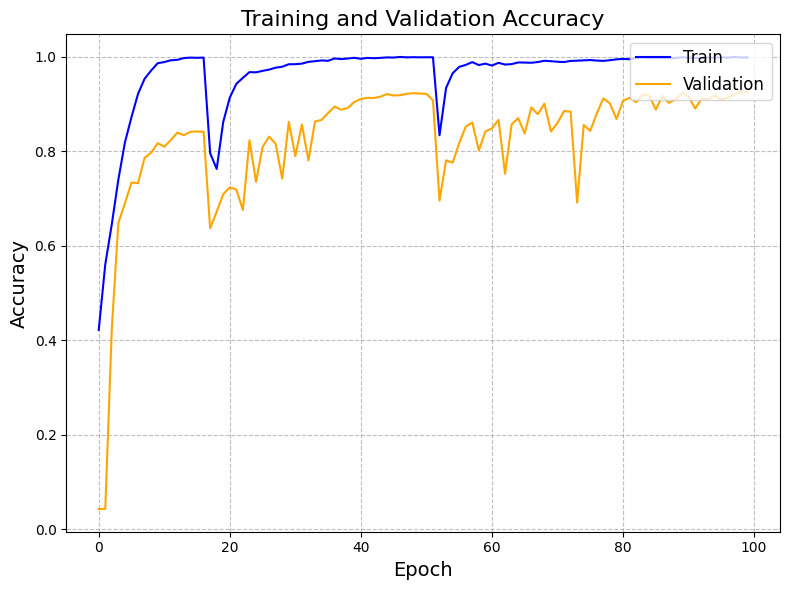

In [51]:
plt.figure(figsize=(8, 6))  # Increase figure size
plt.plot(history.history['accuracy'], linestyle='-', color='blue', label='Train')  # Adjust line color
plt.plot(history.history['val_accuracy'], linestyle='-', color='orange', label='Validation')  # Adjust line color
plt.title('Training and Validation Accuracy', fontsize=16)  # Increase title font size
plt.xlabel('Epoch', fontsize=14)  # Increase x-axis label font size
plt.ylabel('Accuracy', fontsize=14)  # Increase y-axis label font size
plt.legend(loc='upper right', fontsize=12)  # Adjust legend location and font size
plt.grid(True, linestyle='--', alpha=0.5, color='gray')  # Add gridlines with a dashed style
plt.tight_layout()  # Adjust layout for better spacing
plt.savefig('CResPIE-ViT acc graph.png', dpi=600)
plt.show()

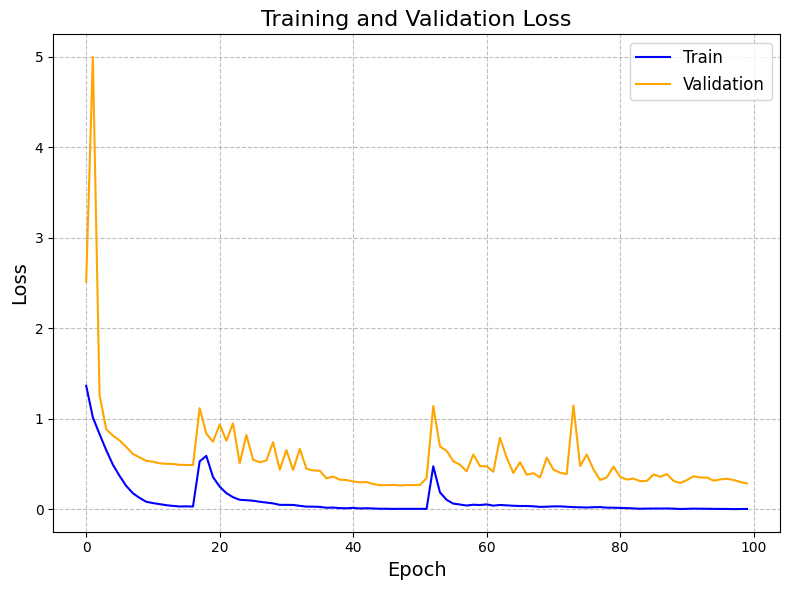

In [52]:
plt.figure(figsize=(8, 6))  # Increase figure size
plt.plot(history.history['loss'], linestyle='-', color='blue', label='Train')  # Adjust line color
plt.plot(history.history['val_loss'], linestyle='-', color='orange', label='Validation')  # Adjust line color
plt.title('Training and Validation Loss', fontsize=16)  # Increase title font size
plt.xlabel('Epoch', fontsize=14)  # Increase x-axis label font size
plt.ylabel('Loss', fontsize=14)  # Increase y-axis label font size
plt.legend(loc='upper right', fontsize=12)  # Adjust legend location and font size
plt.grid(True, linestyle='--', alpha=0.5, color='gray')  # Add gridlines with a dashed style
plt.tight_layout()  # Adjust layout for better spacing
plt.savefig('CResPIE-ViT loss graph.png', dpi=600)
plt.show()

In [37]:
load_model = tf.keras.models.load_model('/kaggle/working/model.h5',
                                   custom_objects={'ChannelAttentionModule':ChannelAttentionModule,
                        'SpatialAttentionModule':SpatialAttentionModule})

# Performance Evaluation

In [38]:
load_model.evaluate(X_test, y_test)

53/53 [==============================] - 6s 71ms/step - loss: 0.3030 - accuracy: 0.9268


[0.30301225185394287, 0.9267706871032715]

In [39]:
y_pred = load_model.predict(X_test)

53/53 [==============================] - 5s 68ms/step


In [40]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 0, 0, ..., 3, 3, 3])

In [41]:
y_true = y_test

In [42]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       381
           1       0.93      0.96      0.95      1026
           2       0.93      0.82      0.87       188
           3       0.89      0.89      0.89        71

    accuracy                           0.93      1666
   macro avg       0.92      0.89      0.90      1666
weighted avg       0.93      0.93      0.93      1666



In [43]:
print(confusion_matrix(y_true, y_pred))

[[339  39   2   1]
 [ 23 988  10   5]
 [  3  29 154   2]
 [  1   7   0  63]]
